# Deepdive

In [1]:
from bhad import (model, utils)
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

### Draw from a two-component multivariate Student-t mixture distribution

Note: Anomaly class corresponds to the minority mixture component

In [2]:
seed = 42  
outlier_prob_true = .01         # probab. for outlier ; should be consistent with contamination rate in your model
k = 30                          # feature dimension 
N = 2*10**4                     # sample size

# Specify first and second moments for each component  
bvt = utils.mvt2mixture(thetas = {'mean1' : np.full(k,-1), 'mean2' : np.full(k,.5), 
                                'Sigma1' : np.eye(k)*.4, 'Sigma2' : np.eye(k)*.1, 
                                'nu1': 3.*k, 'nu2': 3.*k}, seed = seed, gaussian = False)

# Get latent draws and observations:
#------------------------------------
y_true, dataset = bvt.draw(n_samples = N, k = k, p = outlier_prob_true)

print(dataset.shape)

(20000, 30)


In [3]:
y_true.mean()    # probab. latent class 1 (=anomaly)

0.01025

In [4]:
yy = dataset['var0'].values

Plot Bart Simpson density:

In [5]:
import matplotlib.pyplot as plt
from scipy.stats import norm

x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 1000)

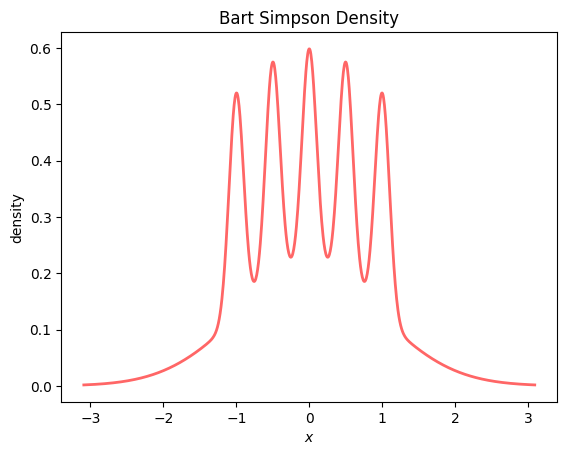

In [6]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, utils.bart_simpson_density(x, m = 4), 'r-', lw=2, alpha=0.6, label='norm pdf')
ax.set_xlabel(r'$x$')
ax.set_ylabel('density')
ax.set_title(r'Bart Simpson Density')
#fig.savefig('bart_simpson_density.png')   # save the figure to file
plt.show();
#plt.close(fig);    # close the figure window

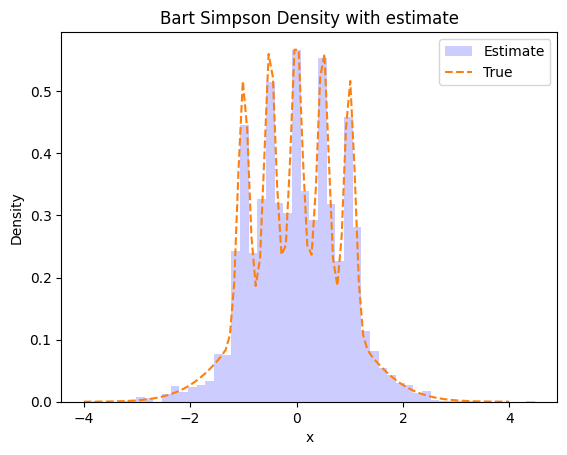

In [7]:
opt_M = 50

grid = np.linspace(-4,4,100)

# Draw a sample via Accept/Reject sampling:
#-------------------------------------------
y = utils.rbartsim(MCsim = 10**4, seed = 42, verbose = False)

y_true = utils.bart_simpson_density(grid, m = 4)

#-----------------------------------------------------------------------------------------------------
fig = plt.figure()
plt.hist(y, bins=opt_M + 1, density=True, facecolor='b', alpha=0.2, label='Estimate'); main = 'Bayes'
#plt.hist(y, bins=opt_fd + 1, density=True, facecolor='b', alpha=0.2); main = 'Freedman-Diaconis'
#plt.hist(y, bins=opt_sturges + 1, density=True, facecolor='b', alpha=0.2); main = 'Sturges'
plt.plot(grid, y_true, linestyle='dashed', label='True')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.title('Bart Simpson Density with estimate')    #  with Bayes estimate number of bins
#fig.savefig(f'est_Bart_{main}.png')   # save the figure to file

plt.show();
#plt.close(fig)    # close the figure window

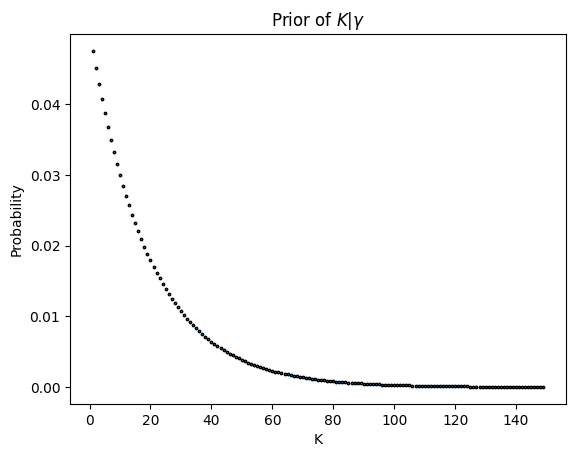

In [23]:
max_M = 150
gamma = 0.95
gp = [utils.geometric_prior(m, gamma = gamma, max_M = max_M) for m in range(1,max_M, 1)] 

fig = plt.figure()
ax = plt.axes()
ax.scatter(range(1,max_M, 1), gp, s=3, edgecolors='black')
ax.set_xlabel(r'K')
ax.set_ylabel('Probability')     # unnormalized
ax.set_title(r'Prior of $K|\gamma$');

In [11]:
from scipy.integrate import simpson

gamma_grid = np.linspace(1e-4,1-1e-4, 30)

prior_max_M = 100
log_marg_prior_nbins = {}
for m in range(1, 100, 1):
    
    prior = np.array([utils.geometric_prior(M = m, gamma = g, max_M = prior_max_M, log = False) for g in gamma_grid])

    #area = simpson(utils.exp_normalize(prior), gamma_grid)
    area = simpson(prior, gamma_grid)
    
    log_marg_prior_nbins[m] = np.log(1e-10 + area)

log_marg_prior_nbins[58]

-7.925919642250673

In [12]:
log_marg_post = {m : log_marg_prior_nbins[m] + utils.log_marglike_nbins(M = m, y = y) for m in range(1, prior_max_M, 1)}

# Compute K_MAP for each feature:
#---------------------------------
nbins = max(log_marg_post, key=log_marg_post.get)
nbins

55

In [13]:
#log_marg_prior_nbins = {m : np.log(1e-10 + simpson(np.array([utils.geometric_prior(M = m, gamma = g, max_M = prior_max_M, log = False) for g in gamma_grid]), gamma_grid)) for m in range(1, prior_max_M, 1)}
#log_marg_prior_nbins

Plot posterior of number of bins:

In [41]:
post = utils.exp_normalize(np.array(list(log_marg_post.values())))
lpost = list(log_marg_post.values())
xx = np.array(list(log_marg_post.keys()))

In [30]:
#lpr = {m : log_marg_prior_nbins[m] + log_marglike_nbins(M = m, y = v) for m in range(1,self.prior_max_M, 1)}

In [31]:
m = 22

log_marg_prior_nbins = np.log(1e-10 + simpson(np.array([utils.geometric_prior(M = m, gamma = g, max_M = 100, log = False) for g in gamma_grid]), gamma_grid))
log_marg_prior_nbins

-6.25420915398745

In [32]:
#-----------------------------
# HPD of number of bins:
#-------------------------------
sig_level = 0.05
upper = np.sum(np.cumsum(post) <= (1-(sig_level/2))) 
lower = np.sum(np.cumsum(post) <= sig_level/2) 
median = np.sum(np.cumsum(post) <= 0.5) 
map = np.argmax(post) 
print(map)
print((lower, median, upper))

54
(49, 54, 54)


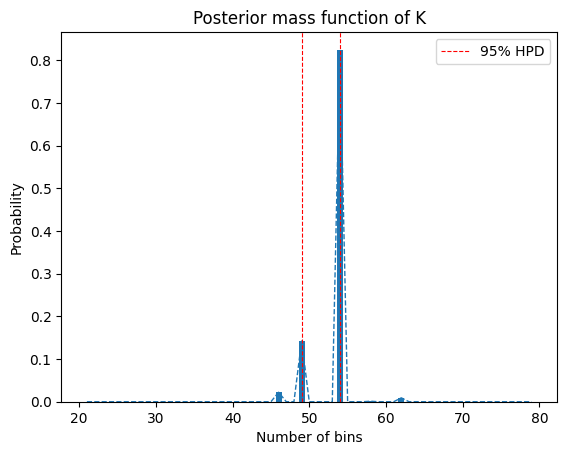

In [40]:
fig = plt.figure()
ax = plt.axes()

s = xx[(xx > 20) & (xx < 80)] 
#ax.plot(xx, post)
ax.plot(s, post[s], '--', linewidth=1)
#ax.bar(s, post)
ax.bar(s, post[s])
#ax.scatter(s, pr)
ax.axvline(x = lower, color = 'red',linestyle = '--', linewidth=0.8, label = f'{int((1-sig_level)*100)}% HPD')
ax.axvline(x = upper, color = 'red',linestyle = '--', linewidth=0.8)
ax.set_xlabel('Number of bins')
ax.set_ylabel('Probability')
ax.legend(loc="upper right")
ax.set_title('Posterior mass function of K')
#fig.savefig('post_k.png')   # save the figure to file
plt.show();
#plt.close(fig)    # close the figure window

### Model training and prediction

In [26]:
reload(model)
reload(utils)

bm = model.BHAD(contamination = 0.01, nbins = None, verbose=True)

y_pred_train = bm.fit_predict(X_train)   
#scores_train = bm.decision_function(X_train)
scores_train = bm.anomaly_scores


-- Construct Bayesian Histogram-based Anomaly Detector (BHAD) --

Computing Bayes estimate for number of bins per dimension.
Finished 'fit' in 40.2535 secs
Finished 'transform' in 0.0245 secs
Discretize continous features.
One-hot encoding categorical features.
Finished 'fit' in 5.4459 secs
Finished 'transform' in 160.5470 secs
Matrix dimension after one-hot encoding: (134000, 1214)
Fit BHAD on discretized data.
Finished training.
Score input data.
Score input data.


In [27]:
y_pred_test = bm.predict(X_test)
#scores_test = bm.decision_function(X_test)
scores_test = bm.anomaly_scores


Score input data.
Discretize continous features.
Finished 'transform' in 248.0836 secs
Apply fitted one-hot encoder.
Finished 'transform' in 79.3549 secs

Score input data.
Discretize continous features.


Plot score distribution:

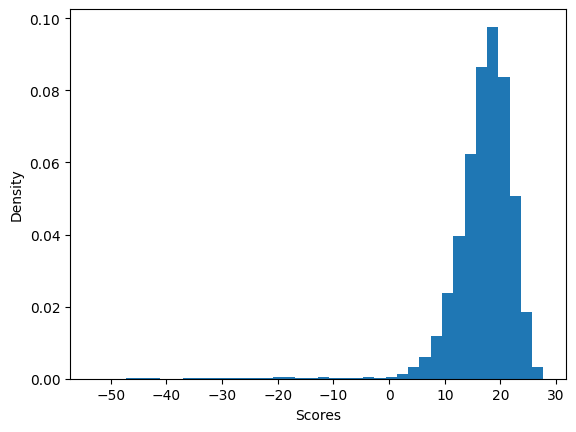

In [11]:
plt.hist(scores_train, density=True, bins=40)  # density=False would make counts
plt.ylabel('Density')
plt.xlabel('Scores');

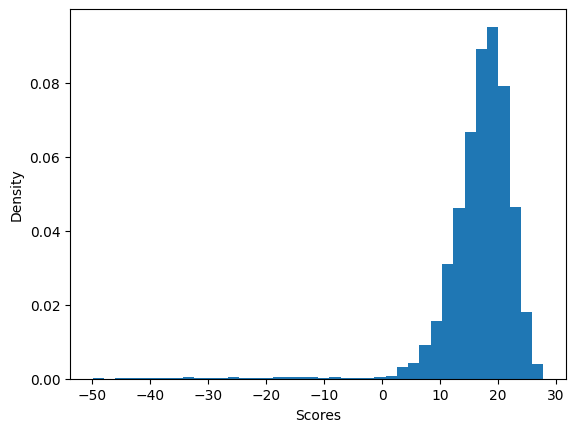

In [12]:
plt.hist(scores_test, density=True, bins=40) 
plt.ylabel('Density')
plt.xlabel('Scores');

In [13]:
from sklearn.metrics import classification_report

# Make comparable to y_true encoding
y_pred_train[y_pred_train == 1] = 0
y_pred_train[y_pred_train == -1] = 1

print(classification_report(y_train, y_pred_train, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       1.00      1.00      1.00     13268
     Outlier       0.95      0.96      0.95       132

    accuracy                           1.00     13400
   macro avg       0.97      0.98      0.98     13400
weighted avg       1.00      1.00      1.00     13400



In [14]:
# Make comparable to y_true encoding
y_pred_test[y_pred_test == 1] = 0
y_pred_test[y_pred_test == -1] = 1

print(classification_report(y_test, y_pred_test, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       1.00      1.00      1.00      6527
     Outlier       0.92      0.99      0.95        73

    accuracy                           1.00      6600
   macro avg       0.96      0.99      0.98      6600
weighted avg       1.00      1.00      1.00      6600

